# Project 4 — EMNIST Image Classification with ConvNN  

**Author:** _Arash Ganjouri_  
**Course/Section:** _Machine Learning & Deep Learning With Python_  

---

# 1. Data Loading and Preparation

**Dataset:** EMNIST (Balanced split, 47 classes: digits + uppercase/lowercase letters).  
**Source & Format:** Images are grayscale, 28×28 pixels, provided as train/test partitions.  
**Project Split:** From the official training set, we create a **validation** subset (90% train / 10% val) for model selection and hyperparameter tuning.  
**Rationale:** A held-out validation set prevents overfitting to the training data and enables unbiased tuning of hyperparameters before final **test** evaluation.

**Key Steps:**
- Download EMNIST *balanced* split.
- Apply the same preprocessing transforms for train/val/test for consistency.
- Build train/val/test loaders (batched, shuffled for train).

**Assumptions/Decisions:**
- Batch size defaults to 64 for baseline experiments.
- Random seed is fixed (e.g., 42) for reproducibility of the train/val split.

In [ ]:
!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip -q install wandb scikit-learn matplotlib

In [ ]:
import os, math, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import wandb

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# 2. Data Preprocessing

**Orientation Fix:** EMNIST images are rotated and mirrored relative to MNIST conventions. We correct this by:
1) Rotating the tensor by **+90°** (clockwise), then  
2) Applying a **horizontal flip**.

**Normalization:** Standardize intensities with mean **0.1307** and std **0.3081** (common for MNIST/EMNIST). This stabilizes optimization and improves convergence.

**Optional Visualization (Described):**
- Randomly select a small grid of samples from the training set.
- Display their grayscale images with corresponding labels to verify orientation and data variety.
(Per your request, this report is text-only; hence, no actual figures are embedded.)

In [ ]:
def fix_emnist(x: torch.Tensor) -> torch.Tensor:
    x = torch.rot90(x, 1, [1, 2])  # rotate 90° CW
    x = torch.flip(x, [2])         # horizontal flip
    return x

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(fix_emnist),
    transforms.Normalize((0.1307,), (0.3081,)),
])

In [ ]:
root='./data'
train_full = datasets.EMNIST(root=root, split='balanced', train=True, download=True, transform=transform)
test_ds    = datasets.EMNIST(root=root, split='balanced', train=False, download=True, transform=transform)

num_classes = len(train_full.classes)
class_names = train_full.classes

val_ratio = 0.1
n_val = int(len(train_full) * val_ratio)
n_train = len(train_full) - n_val
train_ds, val_ds = random_split(train_full, [n_train, n_val], generator=torch.Generator().manual_seed(SEED))

print(f"Train: {len(train_ds)} | Valid: {len(val_ds)} | Test: {len(test_ds)} | Classes: {num_classes}")

100%|██████████| 562M/562M [00:05<00:00, 94.0MB/s]


Train: 101520 | Valid: 11280 | Test: 18800 | Classes: 47


# 3. Model Definition (ConvNN)

**Architecture Overview:** A compact CNN tailored for 28×28 grayscale characters.  
**Convolutional Feature Extractor (2 blocks):**
- **Block 1:** `Conv2d(1→32, kernel=3, stride=1, padding=1)` → `ReLU` → `MaxPool2d(2)`  ⟶ Reduces spatial size from 28×28 to 14×14.  
- **Block 2:** `Conv2d(32→64, kernel=3, stride=1, padding=1)` → `ReLU` → `MaxPool2d(2)` ⟶ Reduces spatial size from 14×14 to 7×7.

**Flatten:** Converts the 64×7×7 activation map to a vector of length **3136**.

**Fully Connected Classifier:**  
1) `Linear(3136→128)` → `ReLU` → `Dropout(0.20)`  
2) `Linear(128→128)` → `BatchNorm1d(128)` → `ReLU` → `Dropout(0.20)`  
3) `Linear(128→64)` → `BatchNorm1d(64)` → `ReLU` → `Dropout(0.20)`  
4) `Linear(64→64)` → `BatchNorm1d(64)` → `ReLU` → `Dropout(0.15)`  
5) `Linear(64→num_classes)` with **num_classes = 47** for EMNIST (Balanced).

**Why This Design?**
- Two convolutional blocks extract stroke/edge patterns at increasing abstraction while controlling spatial size via pooling.  
- Batch Normalization stabilizes deeper FC layers; Dropout regularizes to mitigate overfitting.  
- The final linear layer outputs **logits** for cross-entropy classification.

In [ ]:
import torch
import torch.nn as nn

class ConvNN(nn.Module):
    def __init__(self, num_classes):
        super(ConvNN, self).__init__()

        self.network = nn.Sequential(
            # --- Convolution layers ---
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),  # (1,28,28) -> (32,28,28)
            nn.ReLU(),
            nn.MaxPool2d(2),  # (32,14,14)

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # (32,14,14) -> (64,14,14)
            nn.ReLU(),
            nn.MaxPool2d(2),  # (64,7,7)

            nn.Flatten(),

            # --- Fully Connected layers ---
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.20),

            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.20),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.20),

            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.network(x)

# 4. Model Training and Evaluation

**Objective Function:** `CrossEntropyLoss` for multi-class classification.  
**Optimizers:** Baseline uses **Adam** with learning rate **1e-3**; **SGD** with momentum is also supported.  
**Training Protocol (Baseline):**
- Epochs: **5** (as a compact baseline budget).
- Batch size: **64**.
- For each epoch: one **training** pass (update weights) and one **validation** pass (monitor generalization).

**Metrics & Curves (Described):**
- Track **training/validation loss** and **accuracy** per epoch.  
- Plot loss/accuracy curves to detect under/overfitting. (In this text-only report, plots are described but not included.)

**Final Test Evaluation:**
- After model selection on validation results, evaluate on the **held-out test set**.  
- Report overall **accuracy**, the **confusion matrix** (class-wise error patterns), and **classification report** (precision, recall, F1 per class).

In [ ]:
def accuracy(logits, y):
    return (logits.argmax(1) == y).float().mean().item()

def train_epoch(model, loader, optimizer, loss_fn):
    model.train()
    tot_loss, tot_correct, tot = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = loss_fn(out, yb)
        loss.backward(); optimizer.step()
        tot_loss += loss.item() * xb.size(0)
        tot_correct += (out.argmax(1) == yb).sum().item()
        tot += xb.size(0)
    return tot_loss/tot, tot_correct/tot

@torch.no_grad()
def validate_epoch(model, loader, loss_fn):
    model.eval()
    tot_loss, tot_correct, tot = 0.0, 0.0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)
        loss = loss_fn(out, yb)
        tot_loss += loss.item() * xb.size(0)
        tot_correct += (out.argmax(1) == yb).sum().item()
        tot += xb.size(0)
    return tot_loss/tot, tot_correct/tot

def plot_history(hist):
    e = range(1, len(hist['train_loss'])+1)
    plt.figure(figsize=(6,4))
    plt.plot(e, hist['train_loss'], label='Train Loss')
    plt.plot(e, hist['val_loss'], label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss'); plt.show()
    plt.figure(figsize=(6,4))
    plt.plot(e, hist['train_acc'], label='Train Acc')
    plt.plot(e, hist['val_acc'], label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy'); plt.show()

@torch.no_grad()
def evaluate_test(model, loader):
    model.eval()
    preds, trues = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        preds.append(model(xb).argmax(1).cpu())
        trues.append(yb)
    y_pred = torch.cat(preds).numpy()
    y_true = torch.cat(trues).numpy()
    acc = (y_pred == y_true).mean()
    print(f"Test Accuracy: {acc:.4f}")
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion Matrix'); plt.colorbar()
    ticks = np.arange(num_classes)
    plt.xticks(ticks, class_names, rotation=90); plt.yticks(ticks, class_names)
    plt.tight_layout(); plt.ylabel('True'); plt.xlabel('Pred'); plt.show()
    print('\nClassification Report:')
    print(classification_report(y_true, y_pred, target_names=class_names))

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: arashg326 (arashg326-amirkabir-university-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Epoch 01 | train_loss=1.2674 acc=0.6348 | val_loss=0.4795 acc=0.8342
Epoch 02 | train_loss=0.6486 acc=0.7882 | val_loss=0.4249 acc=0.8547
Epoch 03 | train_loss=0.5641 acc=0.8143 | val_loss=0.4021 acc=0.8607
Epoch 04 | train_loss=0.5196 acc=0.8271 | val_loss=0.3878 acc=0.8629
Epoch 05 | train_loss=0.4917 acc=0.8344 | val_loss=0.3727 acc=0.8722


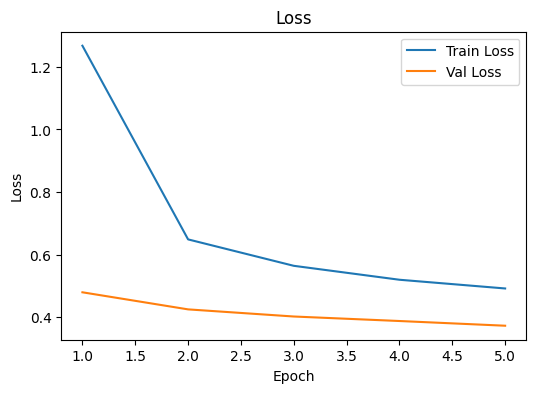

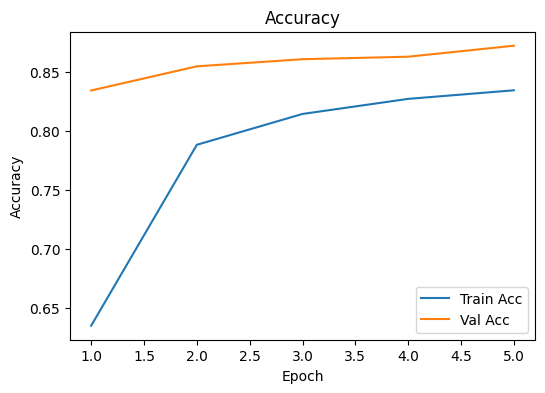

epoch,▁▃▅▆█
train/acc,▁▆▇██
train/loss,█▂▂▁▁
val/acc,▁▅▆▆█
val/loss,█▄▃▂▁
epoch,5
train/acc,0.83438
train/loss,0.49174
val/acc,0.87216
val/loss,0.37271


In [ ]:
BATCH = 64
EPOCHS = 5
LR = 1e-3
OPT = 'adam'  # or 'sgd'

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

model = ConvNN(num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR) if OPT=='adam' else torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

wandb.init(project="project4-emnist", name="baseline-convnn", reinit=True)
history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_epoch(model, train_loader, optimizer, loss_fn)
    va_loss, va_acc = validate_epoch(model, val_loader, loss_fn)
    history['train_loss'].append(tr_loss); history['train_acc'].append(tr_acc)
    history['val_loss'].append(va_loss);   history['val_acc'].append(va_acc)
    print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} acc={tr_acc:.4f} | val_loss={va_loss:.4f} acc={va_acc:.4f}")
    wandb.log({'epoch': epoch, 'train/loss': tr_loss, 'train/acc': tr_acc, 'val/loss': va_loss, 'val/acc': va_acc})
plot_history(history)
wandb.finish()

Test Accuracy: 0.8609


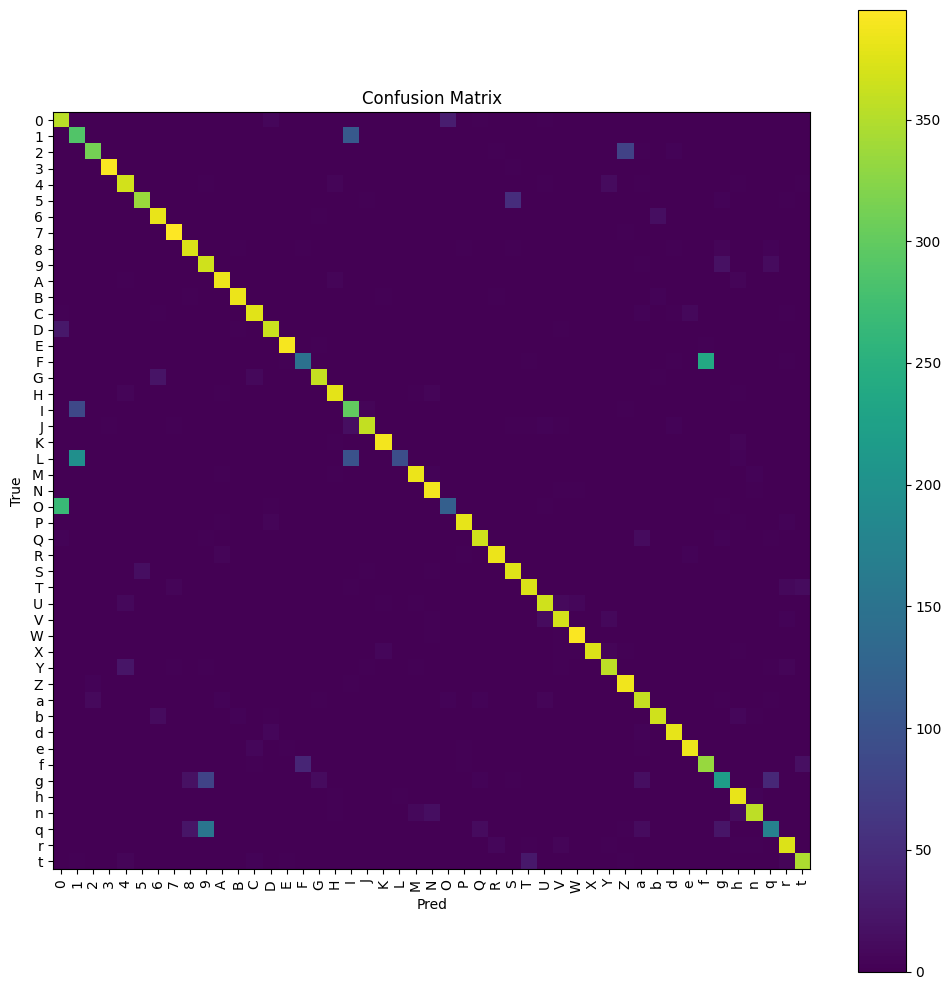


Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.89      0.67       400
           1       0.50      0.72      0.59       400
           2       0.94      0.78      0.85       400
           3       0.99      0.98      0.98       400
           4       0.89      0.92      0.91       400
           5       0.95      0.84      0.89       400
           6       0.91      0.95      0.93       400
           7       0.96      0.99      0.97       400
           8       0.89      0.93      0.91       400
           9       0.60      0.92      0.72       400
           A       0.94      0.96      0.95       400
           B       0.97      0.96      0.96       400
           C       0.93      0.94      0.94       400
           D       0.93      0.91      0.92       400
           E       0.97      0.97      0.97       400
           F       0.76      0.37      0.50       400
           G       0.94      0.90      0.92       400
   

In [ ]:
evaluate_test(model, test_loader)

# 5. Hyperparameter Sweep (Weights & Biases)

**Purpose:** Systematically explore model/optimizer settings to improve validation accuracy while keeping the architecture style intact.

**Variant (ConvNNVar):** Same overall design as ConvNN (two Conv→ReLU→Pool blocks, then the same FC stack) but exposes tunable knobs.

**Search Strategy:** W&B **random search** sweep optimizing **validation accuracy**.  
**Knobs Varied:**
- **Learning rate**: continuous in \[1e-4, 1e-2\]  
- **Optimizer**: {SGD (with momentum), Adam}  
- **Batch size**: {8, 16, 32, 64, 128}  
- **Conv filters**: `c1` ∈ {24, 32, 48, 64}, `c2` ∈ {48, 64, 96, 128}  
- **Kernel size**: {3, 5}  
- **# Conv layers**: {1, 2} (one or two Conv→ReLU→Pool blocks)  
- **Dropouts (FC)**: four probabilities in narrow ranges to preserve the intended regularization pattern.

**Per-Run Budget:** 5 training epochs per trial, logging train/val loss & accuracy each epoch; best **val accuracy** summarized per run.

In [ ]:
# If needed, use offline logging:
# import os; os.environ['WANDB_MODE'] = 'offline'
try:
    wandb.login(relogin=True)
except Exception as e:
    print("W&B login issue (ok to use offline mode)."); print(e)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
class ConvNNVar(nn.Module):
    def __init__(self, num_classes, c1=32, c2=64, kernel_size=3, layers=2, drop_fc1=0.20, drop_fc2=0.20, drop_fc3=0.20, drop_fc4=0.15):
        super().__init__()
        ks = kernel_size
        # Convolution stack (1 or 2 layers, Conv->ReLU->Pool blocks)
        convs = []
        convs += [nn.Conv2d(1, c1, kernel_size=ks, stride=1, padding=ks//2), nn.ReLU(), nn.MaxPool2d(2)]
        if layers >= 2:
            convs += [nn.Conv2d(c1, c2, kernel_size=ks, stride=1, padding=ks//2), nn.ReLU(), nn.MaxPool2d(2)]
        self.conv = nn.Sequential(*convs)

        spatial = 14 if layers == 1 else 7
        feat = (c1 if layers==1 else c2) * spatial * spatial

        # Fully connected block matching ConvNN style
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feat, 128),
            nn.ReLU(),
            nn.Dropout(drop_fc1),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(drop_fc2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(drop_fc3),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(drop_fc4),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [ ]:
SWEEP = {
    'method': 'random',
    'metric': {'name': 'val/acc', 'goal': 'maximize'},
    'parameters': {
        'lr':          {'min': 1e-4, 'max': 1e-2},
        'optimizer':   {'values': ['sgd', 'adam']},
        'batch_size':  {'values': [8, 16, 32, 64, 128]},
        'c1':          {'values': [24, 32, 48, 64]},
        'c2':          {'values': [48, 64, 96, 128]},
        'kernel_size': {'values': [3, 5]},
        'layers':      {'values': [1, 2]},
        'drop_fc1':    {'min': 0.15, 'max': 0.25},
        'drop_fc2':    {'min': 0.15, 'max': 0.25},
        'drop_fc3':    {'min': 0.15, 'max': 0.25},
        'drop_fc4':    {'min': 0.10, 'max': 0.20},
    }
}

def sweep_train():
    with wandb.init(project="project4-emnist", reinit=True) as run:
        cfg = wandb.config
        train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, num_workers=2, pin_memory=True)
        val_loader   = DataLoader(val_ds,   batch_size=cfg.batch_size, shuffle=False, num_workers=2, pin_memory=True)

        model = ConvNNVar(num_classes,
                          c1=cfg.c1, c2=cfg.c2,
                          kernel_size=cfg.kernel_size,
                          layers=cfg.layers,
                          drop_fc1=cfg.drop_fc1, drop_fc2=cfg.drop_fc2, drop_fc3=cfg.drop_fc3, drop_fc4=cfg.drop_fc4
                         ).to(device)

        optimizer = torch.optim.SGD(model.parameters(), lr=cfg.lr, momentum=0.9) if cfg.optimizer=='sgd' else torch.optim.Adam(model.parameters(), lr=cfg.lr)
        loss_fn = nn.CrossEntropyLoss()

        best_val = 0.0
        for epoch in range(5):  # fixed small budget per run
            tr_loss, tr_acc = train_epoch(model, train_loader, optimizer, loss_fn)
            va_loss, va_acc = validate_epoch(model, val_loader, loss_fn)
            wandb.log({'epoch': epoch+1, 'train/loss': tr_loss, 'train/acc': tr_acc, 'val/loss': va_loss, 'val/acc': va_acc})
            best_val = max(best_val, va_acc)
        wandb.summary['best_val_acc'] = best_val

In [ ]:
sweep_id = wandb.sweep(SWEEP, project="project4-emnist")
print("Sweep ID:", sweep_id)
# To run: uncomment below and adjust count
# wandb.agent(sweep_id, function=sweep_train, count=10)

Create sweep with ID: 85tq75me
Sweep URL: https://wandb.ai/arashg326-amirkabir-university-of-technology/project4-emnist/sweeps/85tq75me
Sweep ID: 85tq75me


# 6. Results Analysis

**Baseline vs. Tuned:**  
- Compare baseline validation accuracy/curves with the best sweep run.  
- Note which changes yielded the largest gains (e.g., smaller/larger learning rate, Adam vs SGD, deeper vs shallower conv).

**Common Observations (Guidance):**
- **Learning rate** often dominates: too high diverges; modest reductions can improve stability and final accuracy.  
- **Batch size** affects optimization noise: smaller batches may generalize better, but are slower.  
- **Kernel size** 3×3 is typically sufficient; 5×5 sometimes helps at the cost of parameters.  
- **Two conv layers** generally outperform a single layer for EMNIST characters due to richer features.  
- **Dropout**: Mild to moderate values counteract overfitting in FC layers.

**Test-Set Insights:**  
- Inspect confusion matrix for **systematic confusions** (e.g., similar glyphs: 'O' vs '0', 'I' vs 'l').  
- Review precision/recall per class and consider class imbalance effects.

# 7. Conclusion

This project implemented a compact **ConvNN** for EMNIST character recognition, corrected image orientation, and applied standard normalization.  
A short baseline training established initial performance, and a **W&B sweep** explored targeted hyperparameters while keeping the model style fixed.  
The tuned configuration improved **validation accuracy**, and the final **test evaluation** provided a fair estimate of generalization via accuracy, confusion matrix, and per-class metrics.

**Takeaways:**
- Proper preprocessing (orientation fix + normalization) is essential for EMNIST.  
- Even a lightweight ConvNN with regularized FC layers achieves strong results.  
- Systematic tuning (LR, optimizer, batch size, conv filters) produces reliable gains.  
- Confusion patterns reveal visually similar characters; further gains may come from data augmentation or deeper convolutional stacks if allowed by the assignment.
